In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, optimizers, layers, metrics
from PipelineStages import Loader, ImageProcessing, Labeler, DatasetBuilder, ModelTrainer

2023-07-12 16:23:04.414886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [68]:
def architecture_1(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Normalization())
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu', padding='same'))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu', padding='same'))
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

def architecture_3(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.RandomFlip())
    network.add(layers.RandomRotation(1))
    network.add(layers.Normalization())
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    #network.add(layers.MaxPooling2D(pool_size=(2, 2)))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Flatten())
    network.add(layers.Dense(n_filters[1], activation='sigmoid'))
    network.add(layers.BatchNormalization())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

In [48]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 25ms"

In [49]:
loader = Loader.Loader(100, 20, path, path + "/model1.h5")
stack, tot_loops, info = loader.run()

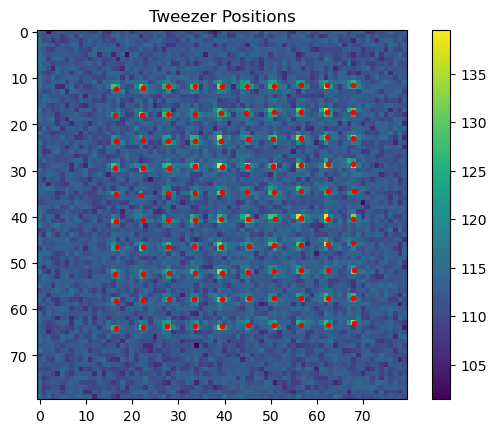

In [50]:
processor = ImageProcessing.ImageProcessor(stack, 100, tot_loops)
crops3x3, crops1x1, positions, info = processor.run()

(100, 25900)


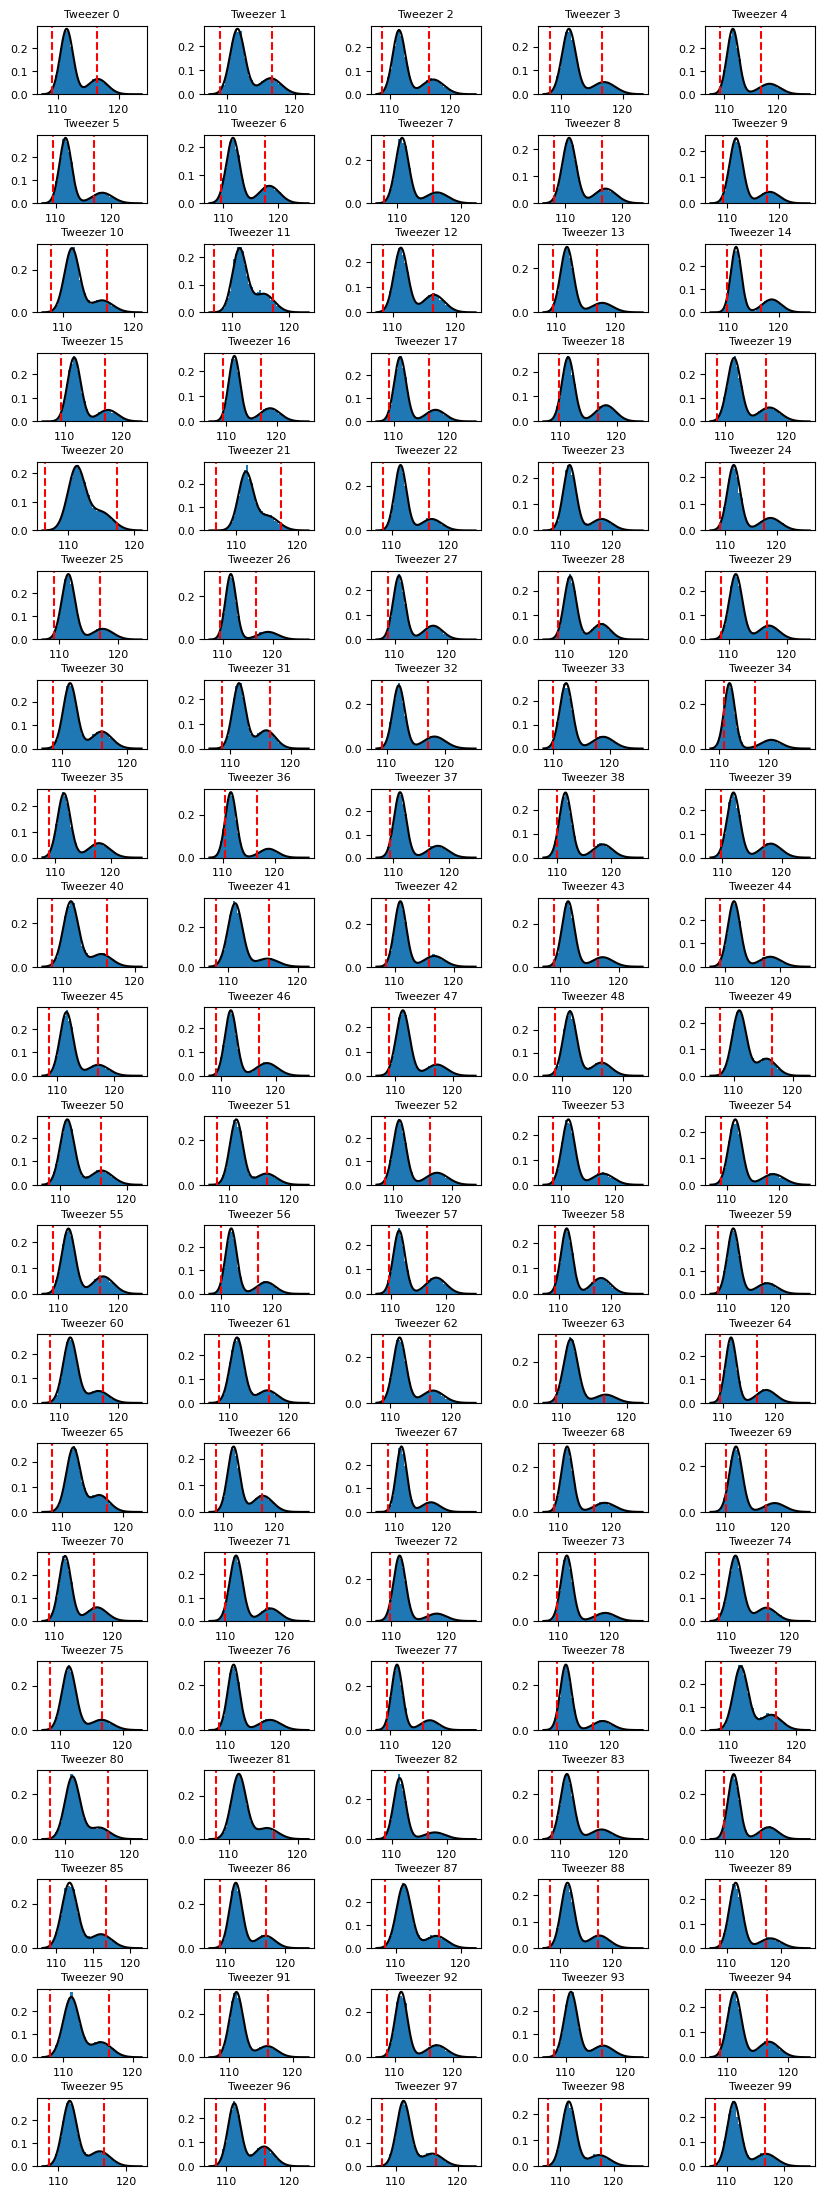

In [7]:
labeler = Labeler.Labeler(crops1x1, 100, tot_loops)
labels, info = labeler.run()

In [8]:
info

{'Histogram fits plot': <Figure size 850x2200 with 100 Axes>,
 'Thresholds': array([[109.07329609, 116.44376607],
        [108.93398958, 116.65211785],
        [108.68348428, 116.57070806],
        [108.3368918 , 116.65043951],
        [109.24199651, 116.83621672],
        [109.55634994, 116.99064474],
        [109.54909485, 117.52964269],
        [107.94599846, 115.67640129],
        [108.08707079, 116.51480789],
        [109.13400413, 117.73582497],
        [108.32516968, 116.2946421 ],
        [107.04441997, 117.20443244],
        [108.52917246, 116.45648746],
        [109.36172403, 117.01116531],
        [109.70563159, 116.54449736],
        [109.34488234, 117.16312747],
        [109.33132739, 116.98889162],
        [109.0820873 , 116.45533854],
        [109.66500886, 116.60708042],
        [108.81357479, 116.77009958],
        [106.50521788, 117.41345629],
        [106.73506057, 117.1959916 ],
        [108.47351235, 116.55495987],
        [108.60103965, 117.7226059 ],
        [109

[False False False ... False False False]
(3077,)


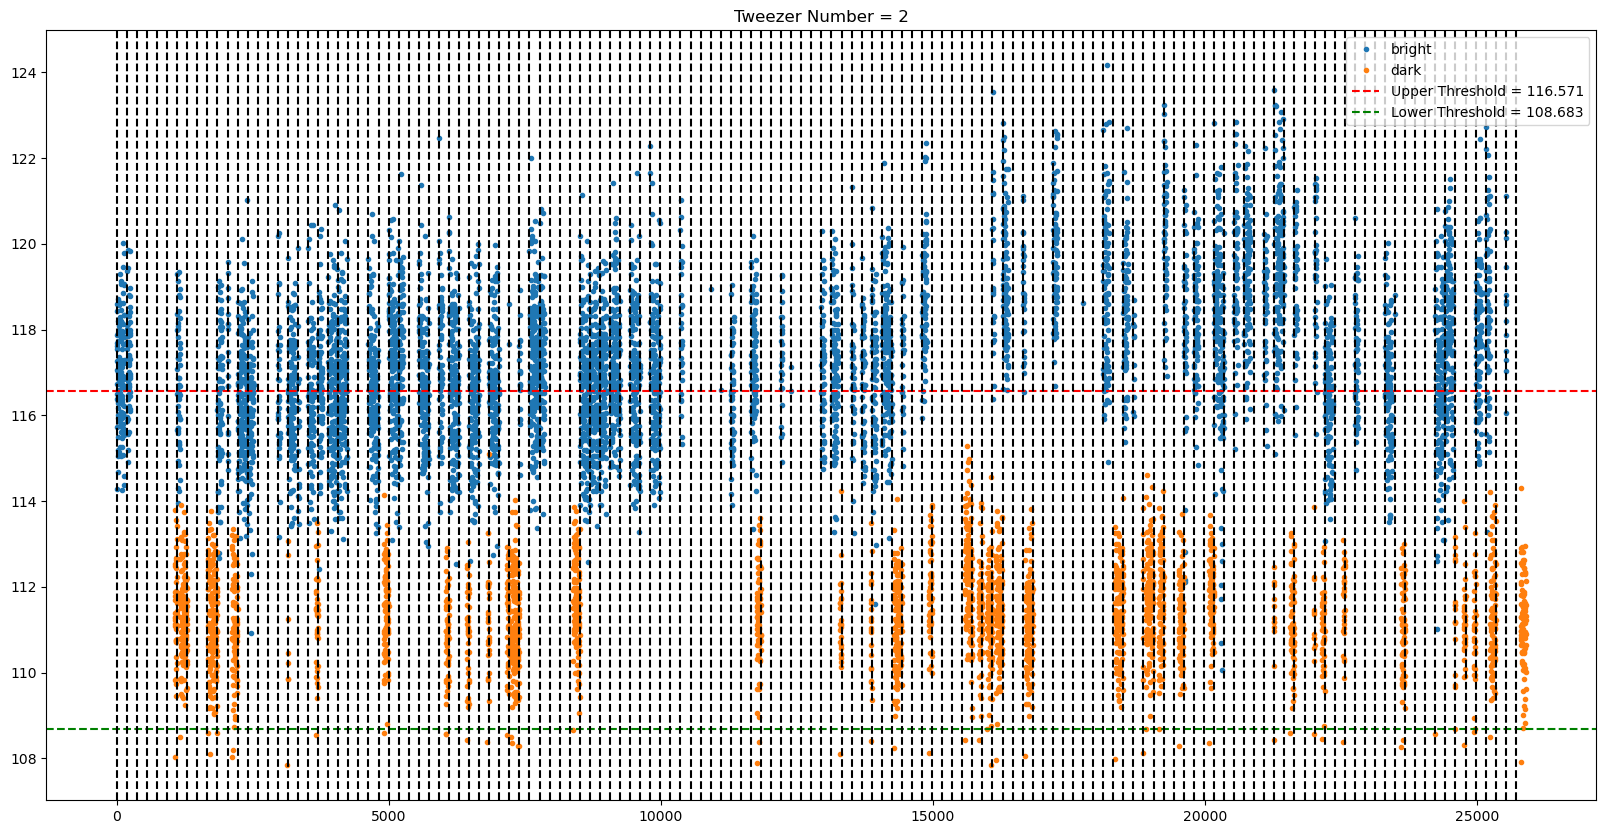

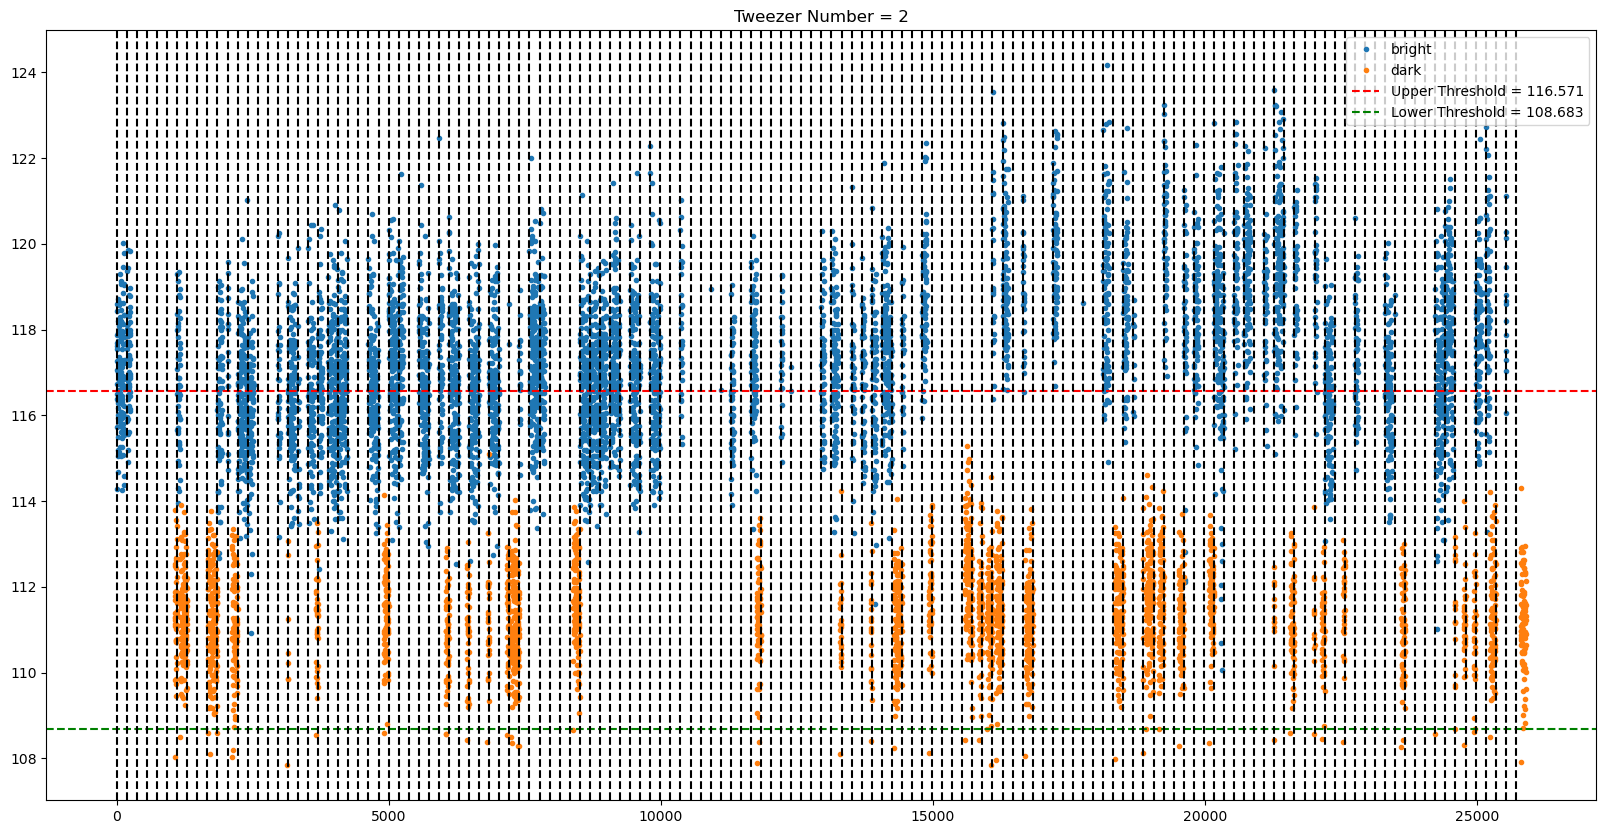

In [9]:
labeler.threshold_plot(2)

In [10]:
builder = DatasetBuilder.DatasetBuilder(crops3x3, labels, 100, tot_loops)
training, testing, fidelity, info = builder.run()

In [12]:
training = list(training)

In [73]:
def add_bright_pixels(training):
    # in training data set randomly select 10% of dark images and add a bright pixel to region around atom
    # First select dark indices only?
    dark_indices = np.where(training[1][:, 1] == 0)[0]
    # Pick dark images to add spurious pixels to
    spurious_indices = np.random.choice(dark_indices, int(0.15 * len(dark_indices)), replace=False)
    # Pick locations of spurious pixel in each image
    locations = np.random.choice([1, -1], size=(len(spurious_indices), 2)) * (np.random.randint(0, 6, size=(len(spurious_indices), 2))) + training[0].shape[-1] // 2 + 1
    # Pick values to set for those locations; start by choosing a Gaussian distribution centered arond 190 with std of 10
    vals = np.random.normal(loc=190, scale=10, size=len(spurious_indices))
    for loc, val, i in zip(locations, vals, spurious_indices):
        training[0][i, loc[0], loc[1]] = val
    return training

def make_dark_images(shape, number, means, stds):
    crops = []
    labels = np.array([np.ones(number * len(means)), np.zeros(number * len(means))])
    for mean, std in zip(means, stds):
        crops.append(np.random.normal(mean, std, size=shape))
    return np.concatenate(crops, axis=0), labels.T

In [ ]:
training = add_bright_pixels(training)
crops, labels = make_dark_images((17, 17) )
training[0] = np.append(training[0], )

In [69]:
model = architecture_3(crops3x3.shape[2:], [16, 8], [3, 3])
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy',
               metrics=['binary_accuracy'])

In [70]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_14 (RandomFlip)  (None, 17, 17, 1)        0         
                                                                 
 random_rotation_14 (RandomR  (None, 17, 17, 1)        0         
 otation)                                                        
                                                                 
 normalization_14 (Normaliza  (None, 17, 17, 1)        3         
 tion)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 17, 17, 16)        160       
                                                                 
 batch_normalization_24 (Bat  (None, 17, 17, 16)       64        
 chNormalization)                                                
                                                     

In [71]:
trainer = ModelTrainer.ModelTrainer(model, training, testing, fidelity, 100, tot_loops, epochs=8)
model, info = trainer.run()

Epoch 1/8
18324/24417 [=====================>........] - ETA: 1:14 - loss: 0.0336 - binary_accuracy: 0.9928

KeyboardInterrupt: 

In [ ]:
model_training_labels = np.argmax(model.predict(training[0]), axis=1)
threshold_training_labels = np.argmax(training[1], axis=1)

32563/32563 [==============================] - 71s 2ms/step


In [ ]:
model_labels = np.argmax(model.predict(fidelity), axis=1)

80938/80938 [==============================] - 155s 2ms/step


In [ ]:
incorrect_crops = training[0][model_training_labels != threshold_training_labels]
correct_labels = training[1][model_training_labels != threshold_training_labels]
incorrect_labels = model_training_labels[model_training_labels != threshold_training_labels]
incorrect_index_data = training[2][model_training_labels != threshold_training_labels]

Model Guess: 0
Threshold Label: [0. 1.]


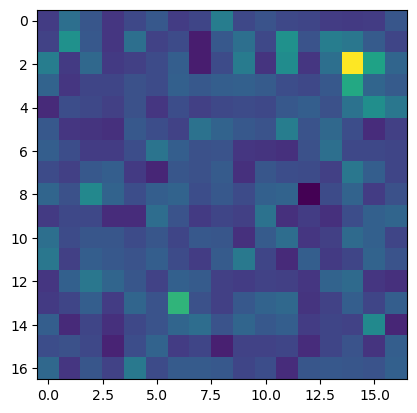

In [ ]:
i = 50
plt.imshow(incorrect_crops[i])
print(f"Model Guess: {incorrect_labels[i]}")
print(f"Threshold Label: {correct_labels[i]}")
#print(incorrect_index_data[i])

In [ ]:
def threshold_plot(img_vals, labels, per_loop, n_loops, tweezer_num):
    tweezer_vals = img_vals[tweezer_num]
    tweezer_labels = labels[tweezer_num * per_loop * n_loops:(tweezer_num + 1)* per_loop * n_loops:]
    bright_mask = tweezer_labels == 1
    dark_mask = tweezer_labels == 0
    bright_indices = np.where(bright_mask)[0]
    bright_vals = tweezer_vals[bright_mask]
    dark_indices = np.where(dark_mask)[0]
    dark_vals = tweezer_vals[dark_mask]
    fig = plt.figure(figsize=(20, 10))
    plt.plot(bright_indices, bright_vals, '.', label='bright')
    plt.plot(dark_indices, dark_vals, '.', label='dark')
    plt.legend(loc='upper right')
    plt.title(f"Tweezer Number = {tweezer_num}")
    for i in range(n_loops):
        plt.axvline(i * per_loop, color='k', linestyle='--', label="Loop Separation")

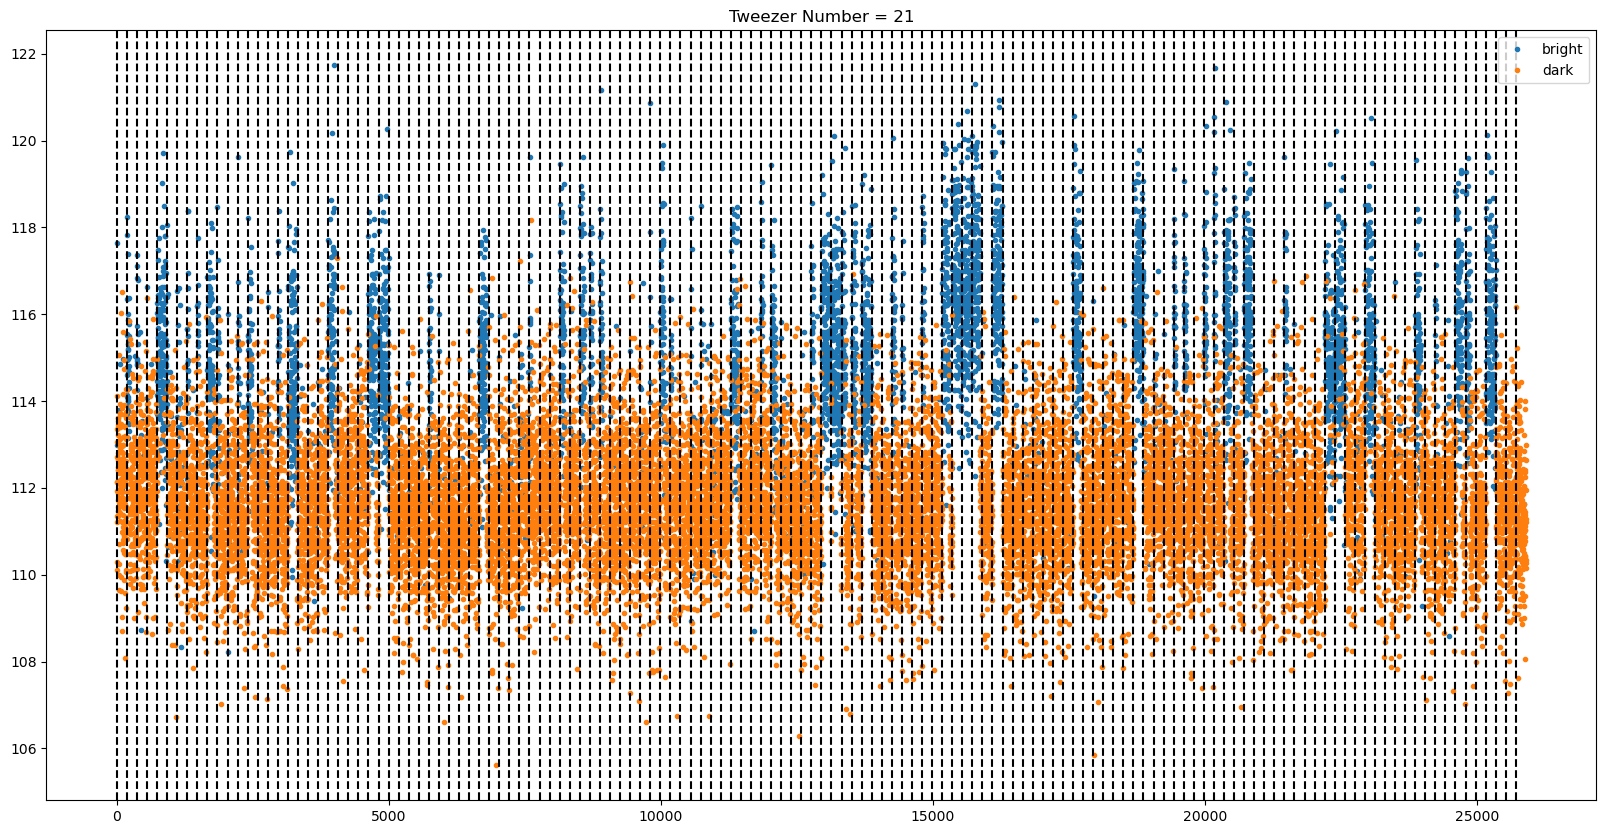

In [ ]:
threshold_plot(np.mean(crops1x1, axis=(2, 3)), model_labels, processor.per_loop, tot_loops, 21)

In [ ]:
def loop_threshold_plot(img_vals, labels, per_loop, n_loops, loop_num, tweezer_num):
    tweezer_vals = img_vals[tweezer_num, per_loop * loop_num:per_loop * (loop_num + 1)]
    tweezer_labels = labels[tweezer_num * per_loop * n_loops + per_loop * loop_num:
                             tweezer_num * per_loop * n_loops + per_loop * (loop_num + 1)]
    bright_mask = tweezer_labels == 1
    dark_mask = tweezer_labels == 0
    bright_indices = np.where(bright_mask)[0]
    bright_vals = tweezer_vals[bright_mask]
    print(labels.shape)
    print(tweezer_num * per_loop * n_loops + per_loop * loop_num)
    dark_indices = np.where(dark_mask)[0]
    dark_vals = tweezer_vals[dark_mask]
    fig = plt.figure(figsize=(20, 10))
    plt.plot(bright_indices, bright_vals, '.', label='bright')
    plt.plot(dark_indices, dark_vals, '.', label='dark')
    plt.legend(loc='upper right')
    plt.title(f"Tweezer Number = {tweezer_num}")
    plt.grid()

(2590000,)
597180


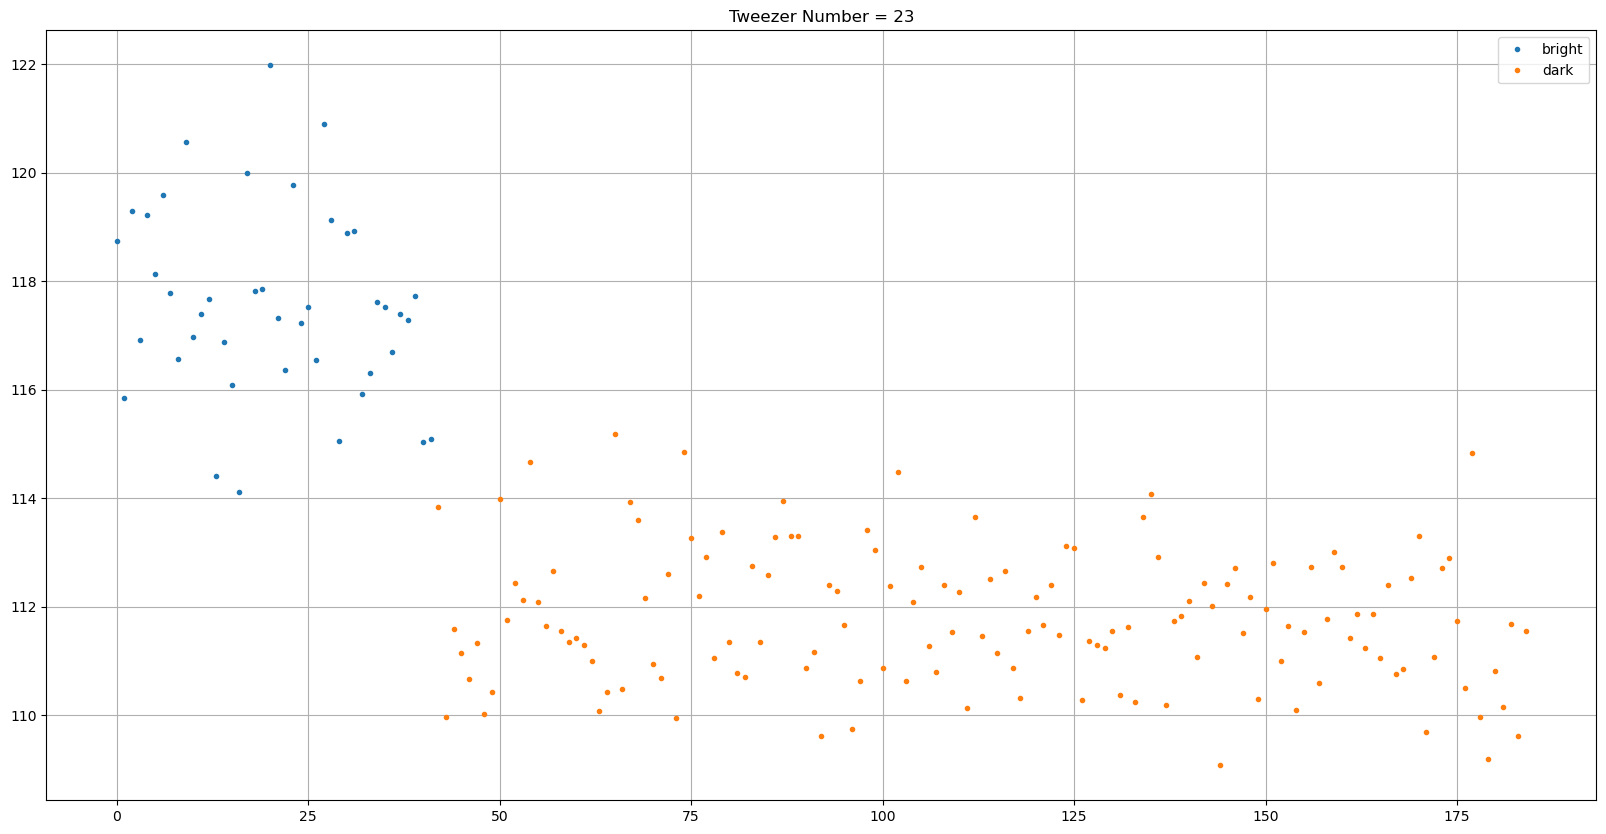

In [ ]:
loop_threshold_plot(np.mean(crops1x1, axis=(2, 3)), model_labels, processor.per_loop, tot_loops, 8, 23)

In [ ]:
def plot_crop(tweezer_num, loop_num, img_num, crops, per_loop):
    crop = crops[tweezer_num, per_loop * loop_num + img_num]
    plt.imshow(crop)
    plt.colorbar()

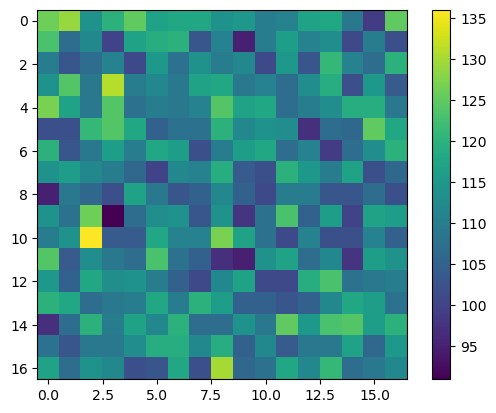

In [ ]:
plot_crop(0, 56, 96, crops3x3, processor.per_loop)

(2590000,)
207200


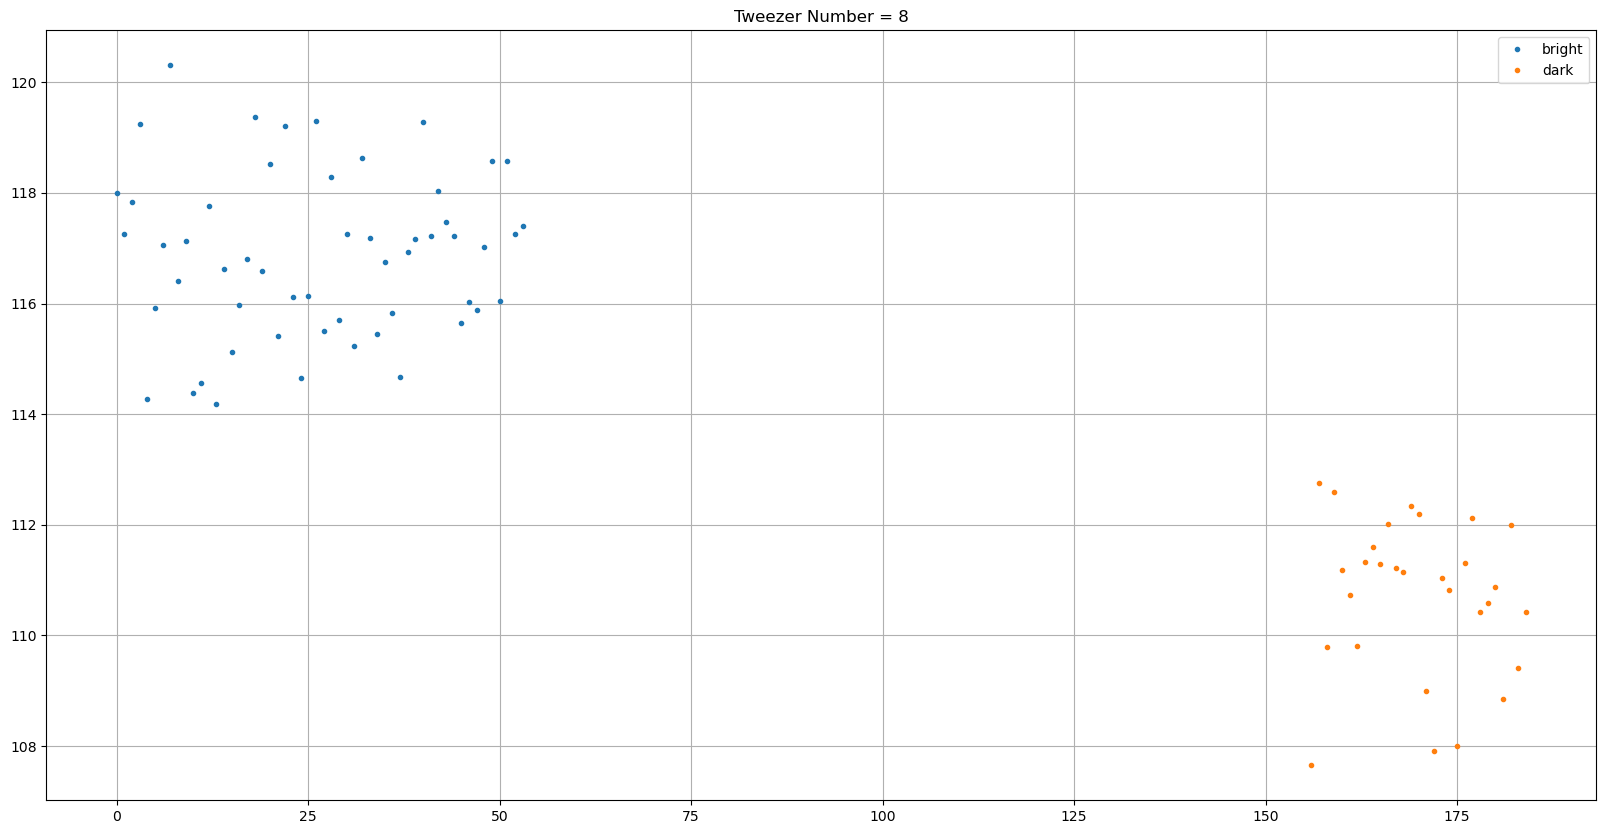

In [ ]:
loop_threshold_plot(np.mean(crops1x1, axis=(2, 3)), labels, processor.per_loop, tot_loops, 0, 8)